 **REIODP: REAL ESTATE INVESTMENT OPPORTUNITY DISCOVERY PROJECT** 
 
 이 프로젝트는 부동산에 대한 내재적 관심을 키우기 위해 진행하고 있는 프로젝트로, 올해 8월 시작하였습니다. 
 <br> 짬짬히 시간 내어 혼자 진행하고 있으며, 본 프로젝트를 통해 향후 부동산 취득과 투자에 있어 안목을 쌓고, 데이터 분석에 대한 자질을 튼실히 다지고자 하였습니다. 
 
 **결과물 측면에서 프로젝트의 목적은 2개가 있습니다**
 1. 전국 아파트의 개별 매력도를 수칙적으로 도출한다 
 2. 지역별 및 특성별 아파트의 중위 값, 평균 값 등을 표본이 아닌 모집단을 대상으로 도출하고, 이를 보기 편하게 시각화하여 Web 앱으로 구현한다.  
 3. 거시 경제 변수들과 부동산 시장의 관계를 도출하고 시장의 cycle을 예측한다 (MIDP: Macroeconomic Insight Discovery Project)
 * MIDP는 따로 진행하고 있습니다. 
 
 
 **프로젝트를 통해 3가지를 배우고자 하였습니다**
 1. AWS의 클라우드 서비스 (특히 EMR, EC2)를 자유롭게 사용할 수 있는 이해를 갖추는 것. 
 2. 하둡 뿐만이 아니라 하둡 생태계에 대한 이해, ETL에 필요한 NIFI, Messaging System인 Kafka 등의 활용 의의와 목적을 이해하는 것 
 3. 부동산 시장에 대한 거시적 + 미시적 이해 
 
본 프로젝트는 아직 진행중이며 내년 6월 쯤에야 완성할 수 있을 것 같습니다. 현재는 ETL프로세스를 완성한 단계이고 '역세권여부'라는 변수 생성을 위해 세부 작업을 하고 있습니다. 

In [2]:
import PublicDataReader as pdr
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from datetime import datetime
import sys 
import os 
import copy 
import glob

plt.style.use("seaborn")

In [3]:
print(pdr.__version__)


>>> PublicDataReader Version : 0.1.1

- Author : Wooil Jeong
- E-mail : wooil@kakao.com
- Github : https://github.com/WooilJeong/PublicDataReader
- Blog : https://wooiljeong.github.io



# 서비스키 정의, PublicDataReader를 통해 데이터 확보 

In [4]:
serviceKey = "KP%2Brod%2F18X54yfDMWeoyj0iojA6%2B2XoaSBtMNkzwpM8WYmP%2F4HwpbkpRuKVSndM7%2FgY2N%2BPjJJvIirYCoJydng%3D%3D"

Apt = pdr.AptTradeReader(serviceKey)

# 주소에 대한 상세 정보만 있다. 불필요함.
#Apt2 = pdr.AptTradeDetailReader(serviceKey)  
#a = Apt2.DataReader("41135", "202003")

>>> 서비스가 정상 작동합니다.


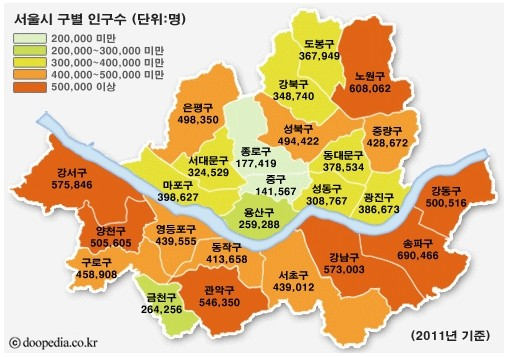

In [4]:
city_list = ["서울특별시", 
             "부산광역시", 
             "대구광역시", 
             "인천광역시", 
             "광주광역시", 
             "대전광역시", 
             "울산광역시", 
             "세종특별시"]

province_list = ["경기도", 
                 "강원도", 
                 "충청북도", 
                 "충청남도",
                 "전라북도", 
                 "전라남도", 
                 "경상북도", 
                 "경상남도", 
                 "제주도"]

행정구역 리스트: 
https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98_%ED%96%89%EC%A0%95_%EA%B5%AC%EC%97%AD#:~:text=%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98%20%ED%96%89%EC%A0%95%20%EA%B5%AC%EC%97%AD(%E5%A4%A7%E9%9F%93%E6%B0%91%E5%9C%8B,%EC%9E%90%EC%B9%98%EC%8B%9C%EB%A1%9C%20%EA%B5%AC%EC%84%B1%EB%90%9C%EB%8B%A4.

동일 **구**에 있는 동들은 모두 같은 법정구코드를 갖는다. 특정 동의 법정구코드를 알려고 한다면: 

함수 리스트: 

1. **Apt.CodeFinder(region)**
---
2. **data = Apt.DataReader(, "202001")**
---
3. **data = Apt.DataCollector("11650", start, end)**

# 프로젝트 목표: 
세부 목표: 
- 지역별 매력도 (구, 동 단위) 
- aggregate 지역별 추세 (구, 동 단위)
- 아파트 개별 매력도 
- 아파트 개별 mispricing 


# ETL 프로세스: Read, Save, Update, Transform 

## 법정구코드 가져오기 

In [7]:
# 법정동명과 법정구코드 DF 저장 

def regional_codes(region): 
    
    df = Apt.CodeFinder(region)
    df = df.drop_duplicates("법정구코드")
    df["법정동명"] = df["법정동명"].str.replace(region+" ", "")
    df.index = range(0,len(df))
    
    print("총 법정동 수 : ",len(df))

    return df


In [318]:
서울 = regional_codes("서울특별시")
대구 = regional_codes("전라북도")

총 법정동 수 :  26
총 법정동 수 :  17


## 실거래가 읽어드리기

**모든 데이터는 os.getcwd()+"/Data/"에 저장된다**

In [16]:
region = "서울특별시"

print(os.listdir(os.getcwd()+"/data/서울특별시"))
print("\n서울특별시 데이터 셋 개수: "+str(len(os.listdir(os.getcwd()+"/data/서울특별시"))))

['관악구.csv', '금천구.csv', '용산구.csv', '동작구.csv', '.DS_Store', '서초구.csv', '서대문구.csv', '양천구.csv', '구로구.csv', '광진구.csv', '강동구.csv', '성동구.csv', '강남구.csv', '동대문구.csv', '영등포구.csv', '중랑구.csv', '은평구.csv', '성북구.csv', '종로구.csv', '강서구.csv', '강북구.csv', '마포구.csv', '노원구.csv', '도봉구.csv', '중구.csv', '송파구.csv']

서울특별시 데이터 셋 개수: 26


## 데이터 새로 받기 

In [ ]:
# 날짜 지정 
start = "2006-01"
end = "2020-07"

# 시작 지점 명시 
starting = 0
region = "서울특별시"
#regional_code= 대구

def get_data(starting):
    
    #region = "대구광역시"
    
    # temp["법정구코드"]는 서울특별시의 모든 지역구의 법정구코드를 담고 있다.       
    for index, code in enumerate(temp.iloc[starting:,1]):

        file_name = regional_code[regional_code["법정구코드"] == code].iloc[0,0]
        print("==== "+file_name+"("+code+")의 데이터를 가져옵니다 ====")

        price_data = Apt.DataCollector(code, start, end)


        print("======================================\n")

        if price_data.empty:
            print("Data가 없습니다\n")
            break         # 서울특별시 11110은 법정구코드만 있을 뿐 데이터를 받아올 수 없다. 따라서 그냥 SKIP. 
        else:
            price_data = pre_process1(price_data)
            price_data.to_csv(os.getcwd()+"/Data/"+region+"/+file_name+".csv",header = True, index=False, encoding = "utf-8-sig")

    print("DATA RETRIEVE COMPLETE")

#get_data()

## 이미 받은 데이터 자동 업데이트 

In [37]:
## 지역에 위치한 모든 파일 출력 

region = "서울특별시"
files = os.listdir(os.getcwd()+"/Data/"+region)

for file in files: 
    if(file.endswith(".csv")):
        data = pd.read_csv("")
        file_name = file.split(".")[0]
        print(file_name)
    

관악구
금천구
용산구
동작구
서초구
서대문구
양천구
구로구
광진구
강동구
성동구
강남구
동대문구
영등포구
중랑구
은평구
성북구
종로구
강서구
강북구
마포구
노원구
도봉구
중구
송파구


In [367]:
# 데이터를 주면 최신 날짜를 파악하고 새로운 날짜 데이터를 읽은 후 통합한 데이터를 반환하는 함수 
def update_data(df, region): 
    
    original_data = copy.deepcopy(df)
    
    year_data = df["거래년도"].max()
    month_data = df[df["거래년도"] == year_data]["거래월"].max()
    
    year_today = datetime.today().year 
    month_today = datetime.today().month
    
    # df의 법정동 코드 
    code = 서울[서울["법정동명"] == df.name]["법정구코드"].values[0]
    
    print("법정구코드 :" +code)
    
    if (year_data <= year_today): 
        
        if (month_data <= month_today): 
            
            # data를 받아오는 시작과 끝 날짜 정의 
            starting_date = str(year_data)+"-"+'{:02d}'.format(month_data)
            end_date = str(year_today)+"-"+'{:02d}'.format(month_today)
            
            # data 읽어드리기 
            added_data = Apt.DataCollector(str(code), starting_date, end_date)
            
            if (not(added_data.empty)):
                #added_data에 pre_process1처리 
                added_data = pre_process1(added_data)

                # original_data가 pre_process(1)되었는지 확인 
                col_list = ['지역코드','거래일','거래년도', '거래월',  '법정동', '지번', '아파트','층','건축년도','전용면적','전용면적(평)','건물나이', '거래금액']
                
                if(original_data.columns.tolist() != col_list): 
                    original_data = pre_process1(original_data)
                
                # original_data의 최근 값 제거 
                added = len(original_data)
                original_data = original_data.drop(original_data[(original_data["거래년도"] == year_data)&(original_data["거래월"] == month_data)].index)
                

                # new_data를 생성하고 index를 새로 지정 
                new_data = pd.concat([original_data, added_data])
                new_data.index = range(0, len(new_data))

                # 총 추가된 데이터 
                added = len(new_data) - added 

                # 이게 이상하게 합치면 거래일 format이 이상해진다. 그래서 바꿔준다. 
                new_data["거래일"] = pd.to_datetime(new_data["거래일"], format = ("%Y-%m-%d"))
                
                # csv로 저장 
                new_data.to_csv(os.getcwd()+"/Data/"+region+df.name+".csv",header = True, index=False, encoding ="utf-8-sig")
                print("******** 업데이트가 완료되었습니다 ********\n----> 추가된 거래: {}\n\n".format(added))
                
                
            else:
                print("업데이트할 데이터가 없습니다.\n")

# 지역을 주면 모든 지역 내 파일을 모두 읽은 후 update_data를 하는 함수 
def update_region(region): 
    
    files = os.listdir(os.getcwd()+"/Data/"+region)
    for file in files: 
        if(file.endswith(".csv")):
            file_name = file.split(".")[0] 
            
            data = pd.read_csv(os.getcwd()+"/Data/서울특별시/"+file)
            data = pre_process1(data)
            data.name = file_name
            data_code = data.iloc[0,0]
            
            print("====== "+file_name+"의 업데이트를 시작합니다 ======")
            update_data(data, region)
            
    print("==== "+region+"의 업데이트가 완료되었습니다 ====")

In [368]:
update_region("서울특별시")

====== 관악구의 업데이트를 시작합니다 ======
법정구코드 :11620
>>> LAWD_CD : 11620 DEAL_YMD : 202009
******* 업데이트가 완료되었습니다 *******
----> 추가된 거래: 0


====== 금천구의 업데이트를 시작합니다 ======
법정구코드 :11545
>>> LAWD_CD : 11545 DEAL_YMD : 202009
******* 업데이트가 완료되었습니다 *******
----> 추가된 거래: 0


====== 용산구의 업데이트를 시작합니다 ======
법정구코드 :11170
>>> LAWD_CD : 11170 DEAL_YMD : 202009
******* 업데이트가 완료되었습니다 *******
----> 추가된 거래: 0


====== 동작구의 업데이트를 시작합니다 ======
법정구코드 :11590
>>> LAWD_CD : 11590 DEAL_YMD : 202009
******* 업데이트가 완료되었습니다 *******
----> 추가된 거래: 0


====== 서초구의 업데이트를 시작합니다 ======
법정구코드 :11650
>>> LAWD_CD : 11650 DEAL_YMD : 202009
******* 업데이트가 완료되었습니다 *******
----> 추가된 거래: 0


====== 서대문구의 업데이트를 시작합니다 ======
법정구코드 :11410
>>> LAWD_CD : 11410 DEAL_YMD : 202008
>>> LAWD_CD : 11410 DEAL_YMD : 202009
조회할 자료가 없습니다.
******* 업데이트가 완료되었습니다 *******
----> 추가된 거래: 0


====== 양천구의 업데이트를 시작합니다 ======
법정구코드 :11470
>>> LAWD_CD : 11470 DEAL_YMD : 202008
>>> LAWD_CD : 11470 DEAL_YMD : 202009
조회할 자료가 없습니다.
******* 업데이트가 완료되었습니다 *******
---

# 데이터 전처리 및 변수 생성 
**데이터의 기본 features는 아래와 같다**
- 지역코드 / 법정동 / 거래일 / 아파트 / 지번 / 전용면적 / 층 / 건축년도 / 거래금액 

<br>

**추가할 features는 다음과 같다** 
- 거래년도 [ pre_process1 ]
- 거래월 [ pre_process1 
- 전용면적(평) [ pre_process1  ] 
- 건물나이 [ pre_process1 ]
- 로얄층 : [ topfloor, featuring2]
- 역세권 (지하철역과 거리 파악)  : geopandas google api 이용해서 지하철역과 아파트의 경도 위도 거리 계산

## 데이터 읽어드리기 

In [23]:
os.listdir(os.getcwd()+"/data/서울특별시")

['용산구.csv', '.DS_Store', '광진구.csv', '성동구.csv', '동대문구.csv', '종로구.csv', '중구.csv']

In [24]:

용산구 = pd.read_csv(os.getcwd()+"/Data/서울특별시/용산구.csv")
data = copy.deepcopy(용산구)

#df2[df2["아파트"].str.find("아크로")==0].drop_duplicates("아파트")

print("Original Data")
display(data.tail())


Original Data


,지역코드,법정동,거래일,아파트,지번,전용면적,층,건축년도,거래금액
21086,11170,효창동,2020-07-29,효창파크푸르지오,274,114.69,12,2010,174000
21087,11170,효창동,2020-07-31,효창맨션,5-495,73.06,4,1969,61000
21088,11170,후암동,2020-07-04,남산애지앙,1-10,44.88,3,2003,35400
21089,11170,후암동,2020-07-13,브라운스톤남산,458,168.41,2,2004,139000
21090,11170,후암동,2020-07-18,미소가,55-24,160.58,4,2004,108000


## 변수 추가

### pre_process1: 거래연도, 거래월, 전용면적 (평), 건물나이 변수 생성 
- 건물나이 = 거래년도 - 건축년도 
- 거래금액 억 단위로 변경 
- 전용면적 평 단위 추가 
- 변수 재정렬

In [287]:
# pre_process1은 csv가 아니라 api를 통해 읽어드린 데이터에 하는 것이다. 
def pre_process1(data): 
    
    # dtype을 바꿔준다 
    data['전용면적'] =  data['전용면적'].astype(np.float32)
    data['건축년도'] =  data['건축년도'].astype(np.int32)
    data['층'] =  data['층'].astype(np.int32)
    data['거래금액'] =  data['거래금액'].astype(np.float32)

    
    # 거래년도, 월 변수 추가 
    data["거래일"] = pd.to_datetime(data["거래일"], infer_datetime_format=True, format = "%y-%m-%d")
    data["거래년도"] = pd.DatetimeIndex(data["거래일"]).year
    data["거래월"] = pd.DatetimeIndex(data["거래일"]).month
    
    # 거래일을 년도-월-일로 표시 
   # data["거래일"] =  data["거래일"].apply(lambda x: x.date())

    # 거래금액을 만원에서 억 단위로 바꾸기 
    data["거래금액"] = round(data["거래금액"] / 10000, 4)

    # 전용면적(평) 추가 
    data["전용면적(평)"] = round(data["전용면적"]/3.3,2)

    # 건물나이 
    data["건물나이"] = data["거래년도"] - data["건축년도"] 
    
    # column reindex 
    col_list = ['지역코드','거래일','거래년도', '거래월',  '법정동', '지번', '아파트','층','건축년도','전용면적','전용면적(평)','건물나이', '거래금액']# col name 순서대로 
    return data.reindex(columns = col_list)


### pre_process2: 층 Loyalty 변수 추가 

- 아파트는 층마다 공시지가와 거래가격이 달라진다. 예를 들어, 동일 조건일 때 1층은 같은 동 최고 시가의 층보다 최소 10% 저렴하게 거래된다. 
- Loyalty분류를 위해 일단 아파트의 최고 층을 파악했다 [**topFloor라는 함수로 apt의 최고층 파악**]
- pre_process2()라는 함수를 통해 data를 for loop을 돌림. 
- 층 분류는 다음과 같다: 
    -  1층 : 최저층 
    -  2층 ~ 40% : **저층**
    -  40% ~70% : **중층** 
    -  70% ~ 최고층 : **고층** 



In [69]:
# 전체 데이터에서 아파트 이름을 입력하면 최고층을 찾는 함수 

def topFloor(data, apt_name): 
    
    temp = data[data["아파트"] == apt_name]
    highest_floor = max(temp["층"])

    number_of_trades = len(temp[temp["아파트"] == apt_name])
    #print("총 거래수 %d 건 " %number_of_trades)
    
    # 총 거래수가 가장 높았던 층 보다 적다면 표본이 충분치 않으므르 0으로 지정한다. 
    if (number_of_trades < highest_floor) : 
        return 0
    else:
        return highest_floor 


#예시: 
#topFloor(data, "월곡두산위브")

In [62]:
def pre_process2(data): 
    
    apt_list = list(data.drop_duplicates(subset = "아파트")["아파트"])

    # 최고층이라는 column 생성 
    data["최고층"] = 0       # 최고층이 입력되지 않은 아파트는 0을 값는다. 
    data["층 분류"] = 0

    # 아파트 리스트에 대해 최고층 변수 생성 
    for i in apt_list:
    
        highest_floor = topFloor(data, i)
        data.loc[data["아파트"] == i, "최고층"]= highest_floor   # .loc를 이용해서 해야 warning 발생하지 않음 
        
    for i in range(0, len(data)):
        if(data.loc[i,"최고층"] == 0): 
            data.loc[i,"층 분류"] = 0
        elif(data.loc[i,"층"] == 1):
            data.loc[i,"층 분류"] = "최저층"
        elif(data.loc[i, "최고층"]*0.7 <= data.loc[i,"층"]):
            data.loc[i,"층 분류"] = "고층"
        elif(data.loc[i, "최고층"]*0.4 <= data.loc[i,"층"] < data.loc[i, "최고층"]*0.7):
            data.loc[i,"층 분류"] = "중층" 
        elif(data.loc[i, "최고층"]*0.4 > data.loc[i,"층"] > 1):
            data.loc[i,"층 분류"] = "저층"
        


In [63]:
pre_process2(data)

In [70]:
data.head()

,지역코드,법정동,거래일,아파트,지번,전용면적,층,건축년도,거래금액,거래년도,거래월,전용면적(평),건물나이,최고층,층 분류
0,11170,도원동,2006-01-05,삼성래미안,23,84.69,18,2001,4.525000e-08,2006,1,25.66,5,22,고층
1,11170,도원동,2006-01-07,삼성래미안,23,84.69,12,2001,4.050000e-08,2006,1,25.66,5,22,중층
2,11170,도원동,2006-01-07,삼성래미안,23,84.69,17,2001,4.400000e-08,2006,1,25.66,5,22,고층
3,11170,도원동,2006-01-10,삼성래미안,23,114.99,22,2001,5.930000e-08,2006,1,34.85,5,22,고층
4,11170,도원동,2006-01-12,삼성래미안,23,84.69,6,2001,3.615000e-08,2006,1,25.66,5,22,저층


### pre_process3: 지하철역과의 거리 파악 

# 검색 기능: 아파트 이름, 거래년도, 평수 등으로 FILTER

In [9]:
data = pd.read_csv(os.getcwd()+"/Data/서울특별시/강남구.csv")
data

,지역코드,거래일,거래년도,거래월,법정동,지번,아파트,층,건축년도,전용면적,전용면적(평),건물나이,거래금액
0,11680,2006-01-02,2006,1,개포동,189,개포주공 4단지,4,1982,35.640,10.800000,24,3.920
1,11680,2006-01-02,2006,1,개포동,656,시영,3,1984,51.180,15.510000,22,6.500
2,11680,2006-01-02,2006,1,개포동,655-1,개포현대200동,8,1986,82.200,24.910000,20,5.800
3,11680,2006-01-03,2006,1,개포동,138,개포주공 3단지,1,1982,41.990,12.720000,24,6.200
4,11680,2006-01-03,2006,1,개포동,12,성원대치2단지아파트,1,1992,33.180,10.050000,14,1.590
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71758,11680,2020-08-03,2020,8,청담동,76-12,라테라스 청담,9,2018,18.620,5.640000,2,3.500
71759,11680,2020-08-04,2020,8,청담동,60,삼성청담공원아파트,10,1999,107.220,32.490002,21,18.450
71760,11680,2020-08-05,2020,8,청담동,15,이편한세상,6,2005,98.050,29.709999,15,18.400
71761,11680,2020-08-10,2020,8,청담동,34-13,청담스위트,5,2015,13.425,4.070000,5,2.400


### 아파트 이름으로 찾기 

In [11]:
# 아파트 이름 찾는 함수 

def find_apt(data, string): 
    apt_list = data.drop_duplicates(subset = "아파트")["아파트"]
    matching = list(apt_list[apt_list.str.contains(string, regex = False)])
    
    if len(matching) == 0: 
        print("결과가 없습니다")
    else: 
        print("== 찾은 결과는 다음과 같습니다 ==")
        return matching
    

# 자이가 들어간 아파트를 찾고 싶다면 
apt_name = "자이"

find_apt(data, apt_name)

== 찾은 결과는 다음과 같습니다 ==


['개포자이(12-2)', '청담자이', '역삼자이']

In [67]:

# 남산센트럴 자이의 데이터를 보고 싶다면 

data[data['아파트'] == "LG한강자이"]

data[data['아파트'] == "남산센트럴 자이"].drop(columns = ["법정동", "지번"]) # 특정 column drop하기


# 아파트의 층


#sy파크힐.describe

# 총 거래 개수 
#len(sy파크힐)   

,지역코드,거래일,아파트,전용면적,층,건축년도,거래금액,거래년도,거래월,전용면적(평),건물나이,최고층,층 분류


In [127]:
data[data["건축년도"] >= 2016].drop_duplicates(subset="아파트")



,지역코드,거래일,거래년도,거래월,법정동,지번,아파트,층,전용면적,전용면적(평),건축년도,건물나이,거래금액
8325,11140,2016-08-12,2016,8,순화동,217,덕수궁롯데캐슬,18,82.3212,24.95,2016,0,8.900
8771,11140,2016-11-05,2016,11,신당동,140-23,신당역솔하임,16,14.0100,4.25,2016,0,1.790
8812,11140,2016-11-19,2016,11,충무로5가,36-2,충무로엘크루메크로시티2,14,22.7500,6.89,2016,0,2.370
9339,11140,2017-05-09,2017,5,흥인동,8,동대문솔하임,16,19.6700,5.96,2016,1,2.300
9731,11140,2017-08-07,2017,8,황학동,846,신당블루카운티,7,59.5600,18.05,2016,1,4.400
9996,11140,2017-12-20,2017,12,만리동2가,176-1,서울역센트럴자이,13,59.9400,18.16,2017,0,8.500
10103,11140,2017-12-25,2017,12,황학동,1743,골드캐슬Ⅲ,6,29.1600,8.84,2017,0,2.720
10353,11140,2018-01-25,2018,1,흥인동,142-1,위더스하임,3,23.8200,7.22,2018,0,2.980
10379,11140,2018-02-22,2018,2,만리동2가,288,서울역한라비발디센트럴,8,84.9774,25.75,2018,0,9.000
10854,11140,2018-05-18,2018,5,황학동,1572,동광팰리스,14,27.9800,8.48,2018,0,2.650


In [146]:
data[data["아파트"] == "신당 KCC 스위첸"]

,지역코드,거래일,거래년도,거래월,법정동,지번,아파트,층,전용면적,전용면적(평),건축년도,건물나이,거래금액
11943,11140,2019-10-23,2019,10,신당동,856,신당 KCC 스위첸,2,84.9,25.73,2019,0,9.601


### 특정 거래가격 이상, 이하의 데이터 추출하기 

In [36]:
data = copy.deepcopy(중구)

price_upper = 100000


In [126]:
os.listdir(os.getcwd()+"/Data/서울특별시")

jiwoo = pd.read_csv(os.getcwd()+"/Data/서울특별시/서초구.csv")
                   
jiwoo.head()
            
    
find_apt(jiwoo, "아크로") 
                

== 찾은 결과는 다음과 같습니다 ==


['방배아크로리버', '아크로비스타', '방배아크로타워', '아크로리버파크', '아크로리버뷰신반포']

# 데이터 시각화 

## 특정 아파트 수익률 시각화 

In [14]:
apt_name = "아크로"
find_apt(data, apt_name)

apt = "아크로힐스논현"

def apt_visualize(data, apt_name, 
                  start = "2006-01", 
                  end = str(datetime.today().year)+"-"+str(datetime.today().month), 
                  range): 
    
    start_year = start.split("-")[0]
    start_month = start.split("-")[1]
    
    end_year = end.split("-")[0]
    end_year = end.split("-")[1]
    
    data = data[data["아파트"]=="아크로힐스논현"].query('거래일 >= start' and 
    
    
    
    

== 찾은 결과는 다음과 같습니다 ==


['대림아크로빌', '현대65동(대림아크로빌아파트)', '아크로힐스논현']

In [29]:
start = "2006-01"
start.split("-")[0]

'2006'

In [58]:
data[data["아파트"]=="아크로힐스논현"].query('"2019-09">= 거래일 >= "2017-01"' )

,지역코드,거래일,거래년도,거래월,법정동,지번,아파트,층,건축년도,전용면적,전용면적(평),건물나이,거래금액
54828,11680,2017-03-25,2017,3,논현동,276-1,아크로힐스논현,18,2014,113.231,34.31,3,15.500
55381,11680,2017-04-20,2017,4,논현동,276-1,아크로힐스논현,21,2014,84.074,25.48,3,12.350
56115,11680,2017-05-08,2017,5,논현동,276-1,아크로힐스논현,19,2014,113.231,34.31,3,15.350
57154,11680,2017-06-02,2017,6,논현동,276-1,아크로힐스논현,9,2014,84.208,25.52,3,12.380
57961,11680,2017-07-12,2017,7,논현동,276-1,아크로힐스논현,19,2014,113.231,34.31,3,15.200
57963,11680,2017-07-14,2017,7,논현동,276-1,아크로힐스논현,12,2014,113.231,34.31,3,15.150
57976,11680,2017-07-23,2017,7,논현동,276-1,아크로힐스논현,8,2014,84.074,25.48,3,12.100
57979,11680,2017-07-25,2017,7,논현동,276-1,아크로힐스논현,11,2014,84.074,25.48,3,12.200
57983,11680,2017-07-27,2017,7,논현동,276-1,아크로힐스논현,23,2014,84.208,25.52,3,12.600
57985,11680,2017-07-28,2017,7,논현동,276-1,아크로힐스논현,24,2014,84.013,25.46,3,12.850


In [38]:
data.query('전용면적 > 20' and '거래년도 > 2016')

,지역코드,거래일,거래년도,거래월,법정동,지번,아파트,층,건축년도,전용면적,전용면적(평),건물나이,거래금액
54134,11680,2017-01-02,2017,1,개포동,656,시영,1,1984,40.530,12.280000,33,8.500
54135,11680,2017-01-04,2017,1,개포동,185,개포주공 6단지,6,1983,83.210,25.220000,34,12.400
54136,11680,2017-01-04,2017,1,개포동,185,개포주공 6단지,5,1983,60.130,18.220000,34,8.950
54137,11680,2017-01-04,2017,1,개포동,141,개포주공 1단지,4,1982,41.980,12.720000,35,9.750
54138,11680,2017-01-06,2017,1,개포동,141,개포주공 1단지,2,1982,50.640,15.350000,35,11.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71758,11680,2020-08-03,2020,8,청담동,76-12,라테라스 청담,9,2018,18.620,5.640000,2,3.500
71759,11680,2020-08-04,2020,8,청담동,60,삼성청담공원아파트,10,1999,107.220,32.490002,21,18.450
71760,11680,2020-08-05,2020,8,청담동,15,이편한세상,6,2005,98.050,29.709999,15,18.400
71761,11680,2020-08-10,2020,8,청담동,34-13,청담스위트,5,2015,13.425,4.070000,5,2.400


In [34]:
data.dtypes

지역코드         int64
거래일         object
거래년도         int64
거래월          int64
법정동         object
지번          object
아파트         object
층            int64
건축년도         int64
전용면적       float64
전용면적(평)    float64
건물나이         int64
거래금액       float64
dtype: object